<a href="https://colab.research.google.com/github/mr-nudo/intelligent-tools/blob/master/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda, Average
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random

# Set random seed

In [2]:
# Set environment variables
os.environ['PYTHONHASHSEED'] = str(25)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Set seed values
np.random.seed(25)
tf.random.set_seed(25)
random.seed(25)

# TODO: Preprocess

In [3]:
# Preprocess the text
def preprocess(text):
    lowercase_text = text.lower()
    words = lowercase_text.split()
    # words = [word for word in words if word.isalpha()]
    return words


# TODO: Build Vocabulary and training data

In [4]:
# Build vocabulary and generate training data
def build_and_prepare_data(words, window_size):
    # Build vocabulary
    vocab = set(words)
    word_to_index = {word: index for index, word in enumerate(vocab)}

    # Generate training data
    contexts = []
    targets = []
    for i in range(window_size, len(words) - window_size):
        context = [word_to_index[words[i - j]] for j in range(1, window_size + 1)] + \
                  [word_to_index[words[i + j]] for j in range(1, window_size + 1)]
        target = word_to_index[words[i]]
        contexts.append(context)
        targets.append(target)

    # Extract contexts and targets from data
    contexts = np.array(contexts)
    targets = np.array(targets)
    max_context_len = max(len(context) for context in contexts)

    # Prepare contexts and targets for training by padding and one-hot encoding
    contexts = pad_sequences(contexts, maxlen=max_context_len, padding='post')
    targets = to_categorical(targets, num_classes=len(vocab))

    return vocab, contexts, targets

# TODO: Build CBOW model

In [5]:
# Define CBOW model function
def build_cbow_model(vocab_size, embed_size, window_size):

    # Total context size is 2 * window_size (context words on each side of the target word)
    context_size = 2 * window_size

    # Define input layer
    input_layer = Input(shape=(context_size,), dtype='int32', name='context_words')

    # Define embedding layer
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=context_size, name='embedding')
    embedded_context = embedding_layer(input_layer)

    # Average the embeddings
    averaging_layer = Lambda(lambda x: tf.reduce_mean(x, axis=1), name='averaging')
    averaged_context = averaging_layer(embedded_context)

    # Define output layer with softmax activation
    output_layer = Dense(vocab_size, activation='softmax', name='output')
    output = output_layer(averaged_context)

    # Build the model
    model = Model(inputs=input_layer, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model

# TODO: Set file path

In [12]:
# import file path
# from google.colab import drive
# drive.mount('/content/drive')
file_path = '/content/small_corpus.txt'

# Running the helper functions

In [13]:
# Read the file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

words = preprocess(text)

# Print vocabulary size
print(f"Number of words: {len(words)}")

# Model parameters
window_size = 2

# Prepare dataset
vocab, contexts, targets = build_and_prepare_data(words, window_size)

vocab_size = len(vocab)
# Print vocabulary size
print(f"Vocabulary size: {vocab_size}")

# Print lengths of contexts and targets
print(f"Length of contexts array: {len(contexts)}")
print(f"Length of targets array: {len(targets)}")

Number of words: 280000
Vocabulary size: 28
Length of contexts array: 279996
Length of targets array: 279996


# Split the data inton training and validation sets

In [14]:
# Splitting the data
contexts_train, contexts_val, targets_train, targets_val = train_test_split(contexts, targets, test_size=0.2, random_state=25)

embed_size = 2

# Train the model

In [11]:
# Create and train the model
model = build_cbow_model(vocab_size, embed_size, window_size)
history = model.fit(contexts_train, targets_train, validation_data=(contexts_val, targets_val), epochs=7, verbose=1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 context_words (InputLayer)  [(None, 4)]               0         
                                                                 
 embedding (Embedding)       (None, 4, 2)              56        
                                                                 
 averaging (Lambda)          (None, 2)                 0         
                                                                 
 output (Dense)              (None, 28)                84        
                                                                 
Total params: 140 (560.00 Byte)
Trainable params: 140 (560.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/7
7000/7000 [==============================] - 49s 7ms/step - loss: 2.3464 - accuracy: 0.1168 - val_loss: 2.2236 - val_accuracy: 0.1334
Epoch 2/7
7

# TODO: Visualise the Training and Validation loss

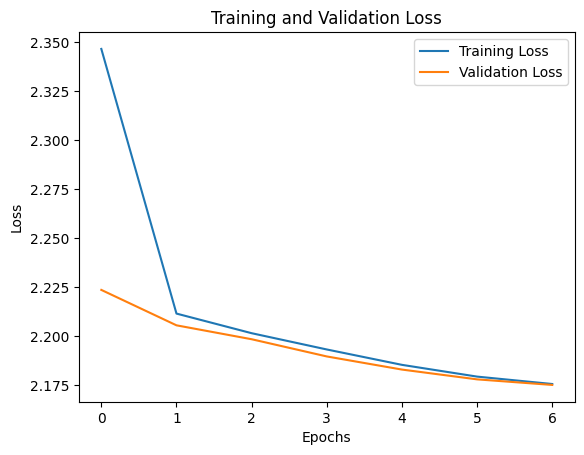

In [29]:
# Plotting the training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# TODO: Extract the embeddings

In [27]:
# Extract embeddings
embeddings = model.get_layer('embedding').get_weights()[0]

# TODO: Find similar words

In [28]:
def cosine_similarity(vec_a, vec_b):
    """Calculate the cosine similarity between two vectors."""
    dot_product = np.dot(vec_a, vec_b)
    norm_vec_a = np.linalg.norm(vec_a)
    norm_vec_b = np.linalg.norm(vec_b)
    similarity = dot_product / (norm_vec_a * norm_vec_b)
    return similarity

def find_similar_words(query_word, vocab, embeddings, top_n=3):
    """Find the top_n words most similar to the query_word based on the embeddings."""

    if isinstance(vocab, set):
        vocab = list(vocab)

    query_index = vocab.index(query_word)
    query_embedding = embeddings[query_index]

    similarities = []

    #populate the similarities list
    for word in vocab:
        if word != query_word:
            word_index = vocab.index(word)
            similarity = cosine_similarity(query_embedding, embeddings[word_index])
            similarities.append((word, similarity))

    # Sort based on similarity scores
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Print top similar words
    print(f"Words most similar to '{query_word}':")
    for word, similarity in similarities[:top_n]:
        print(f"{word}: {similarity:.4f}")



In [25]:
query_words = ['poland', 'thailand', 'morocco']

for query_word in query_words:
    find_similar_words(query_word, vocab, embeddings)
    print("\n")


Words most similar to 'poland':
germany: 0.9997
uk: 0.9997
switzerland: 0.9994


Words most similar to 'thailand':
philippines: 1.0000
indonesia: 0.9999
vietnam: 0.9994


Words most similar to 'morocco':
tanzania: 0.9999
nigeria: 0.9983
ghana: 0.9913




# TODO: Visualise the embeddings

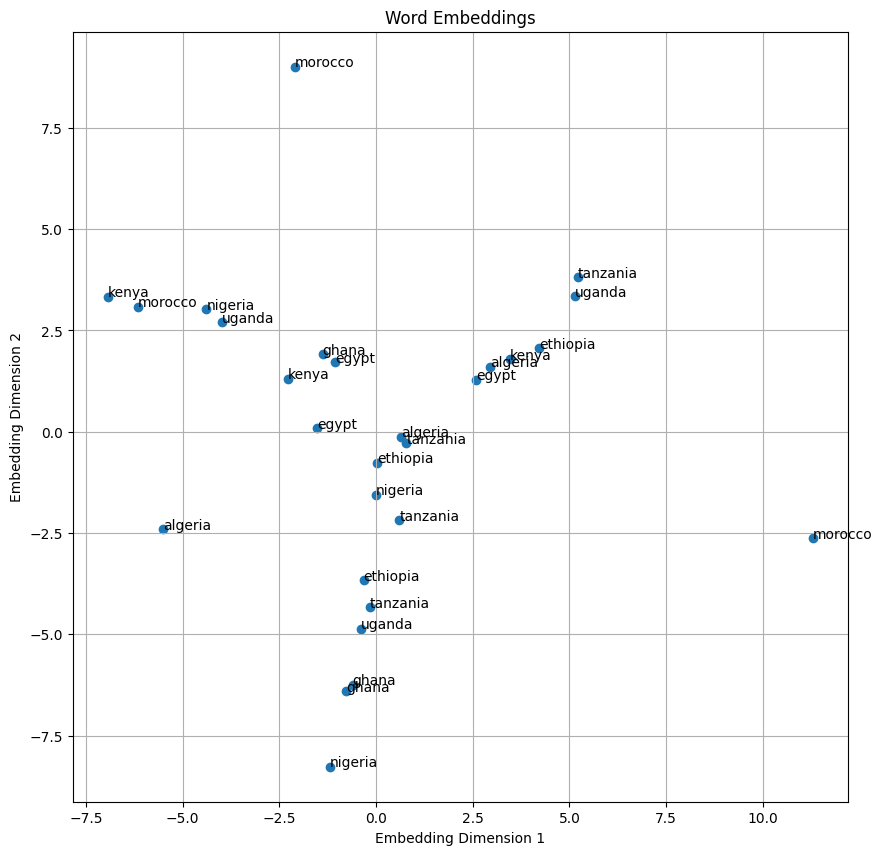

In [26]:
# Create a scatter plot of the embeddings
plt.figure(figsize=(10, 10))
num_words_to_plot = min(len(words), len(embeddings))

plt.scatter(embeddings[:num_words_to_plot, 0], embeddings[:num_words_to_plot, 1])

# Annotate the points with their indices
for i, word in enumerate(words[:num_words_to_plot]):
    plt.annotate(word, (embeddings[i, 0], embeddings[i, 1]))

plt.title("Word Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()

5.6: Consider a small window size, e.g., 2 or 3. In this scenario, is there a possibility that antonyms (opposite words) might end up with similar embeddings? Explain your views.

Yes, there is a possibility that antonyms (opposite words) might end up with similar embeddings when using a small context window size (e.g., 2 or 3) in models like Continuous Bag of Words (CBOW). This happens because these models learn word embeddings based on the local context in which words appear, and antonyms often appear in similar contexts due to their semantic relationships.

For example, the words "hot" and "cold" might both appear in contexts related to weather, temperature, or sensations (e.g., "The weather is very hot/cold today"). In a small window size, the context captured around these words would be very similar. For example, in the sentences "The soup is hot" and "The soup is cold", the context words around "hot" and "cold" (like "The", "soup", and "is") are identical.